# Galaxy Morphology Classification with EfficientNet-B4

### This notebook implements a galaxy morphology classification pipeline using EfficientNet-B4 as the backbone. It covers data loading and augmentation, stratified train/validation/test splits, model definition with a custom classification head, mixed-precision training with AdamW and cosine scheduler, and performance evaluation using confusion matrices and per-class classification reports. The workflow demonstrates end-to-end deep learning for image-based galaxy classification.

## Device Setup

In [ ]:
import torch
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Supress Warnings

In [ ]:
import warnings
warnings.filterwarnings("ignore")
# Supress unnecessary warnings

## Install dependencies

In [ ]:
# Installs the astroNN package, required for dataset loading
!pip install astroNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 130.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.4 MB/s eta 0:00:00


## Import Libraries

In [ ]:
# Imports all necessary libraries for data handling, model building, training, and evaluation
import time
import os
import random
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T

import torch.nn as nn
from torchvision import models

import torch.optim as optim
from torch.cuda import amp

from astroNN.datasets import load_galaxy10
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight


## Load Dataset

In [5]:
images, labels = load_galaxy10()
y = labels.astype(np.int64)
X = images
print("X:", X.shape, X.dtype, " y:", y.shape, y.dtype)

Galaxy10_DECals.h5: 100%|█████████▉| 2.73G/2.74G [00:23<00:00, 117MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10_DECals.h5


Galaxy10_DECals.h5: 2.74GB [00:31, 87.0MB/s]                           


X: (17736, 256, 256, 3) uint8  y: (17736,) int64


## Class Mappings and Visualizations

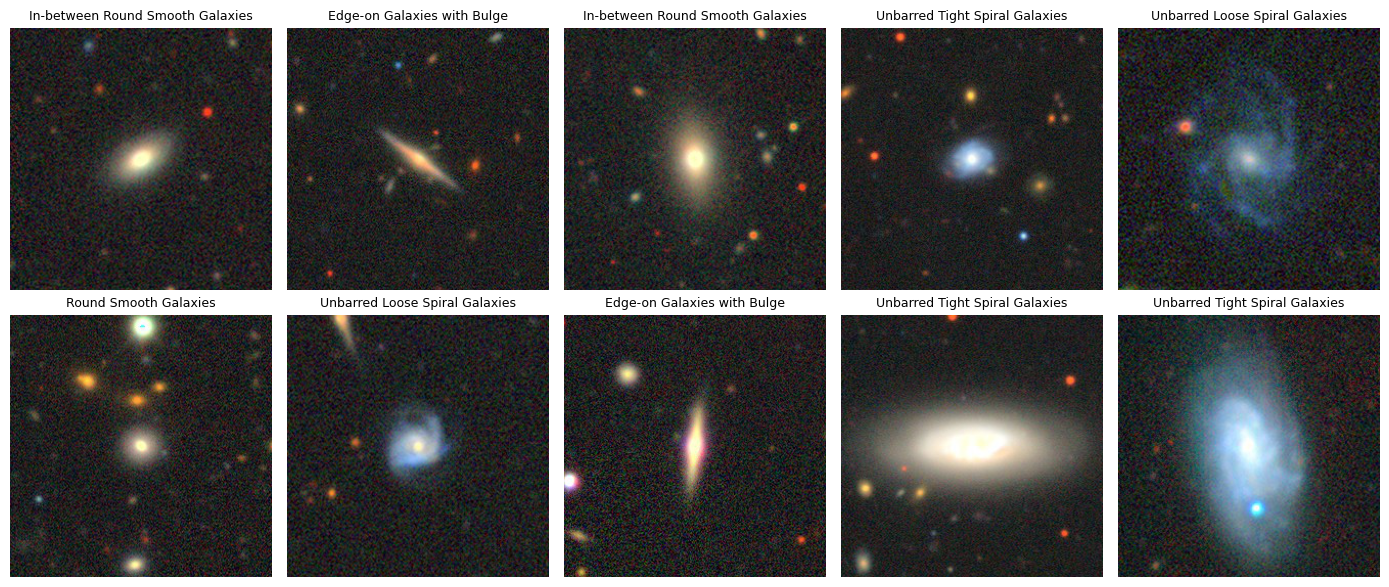

In [6]:

# Class mapping for Galaxy10 DECals
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge",
}

# Plot a few random examples
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
for ax in axes.flat:
    idx = np.random.randint(0, len(images))
    ax.imshow(images[idx])
    ax.set_title(class_names[labels[idx]], fontsize=9)
    ax.axis("off")

plt.tight_layout()
plt.show()

## Dataset class (flip + tiny rotate + color jitter + normalize)

In [7]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class GalaxyDecalsDataset(Dataset):
  def __init__(self, images, labels, img_size=(224,224), train=True):
    self.images = images
    self.labels = labels.astype(np.int64)

    if train:
      self.transform = T.Compose([
        T.Resize(img_size, antialias=True),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=5),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
      ])
    else:
      self.transform = T.Compose([
        T.ToTensor(),
        T.Resize(img_size, antialias=True),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
      ])

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img = Image.fromarray(self.images[index])
    x = self.transform(img)
    y = torch.tensor(self.labels[index], dtype=torch.long)
    return x, y

## Dataloaders (train/val/test)

In [ ]:


# stratified split 
N = len(images)

# First split: train (70%) vs temp (30%)
train_idx, temp_idx = train_test_split(
    np.arange(N),
    test_size=0.30,
    random_state=42,
    stratify=labels
)

# Second split: val (15%) vs test (15%) from temp
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,  # half of 30% = 15%
    random_state=42,
    stratify=labels[temp_idx]
)

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

# Build datasets
train_dataset = Subset(GalaxyDecalsDataset(images, labels, img_size=(224,224), train=True),  train_idx)
val_dataset   = Subset(GalaxyDecalsDataset(images, labels, img_size=(224,224), train=False), val_idx)
test_dataset  = Subset(GalaxyDecalsDataset(images, labels, img_size=(224,224), train=False), test_idx)

# Loaders 
BATCH_SIZE   = 64
NUM_WORKERS  = 4
PIN          = torch.cuda.is_available()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=PIN)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN)

# sanity check
xb, yb = next(iter(train_loader))
print("Batch:", xb.shape, yb.shape, yb.dtype)


Train: 12415, Val: 2660, Test: 2661
Batch: torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.int64


## Model Definition

In [ ]:
## Defines EfficientNet-B4 backbone and custom classification head for weed detection

class EfficientNetGalaxy(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super().__init__()
        # Load EfficientNet-B4 backbone
        m = models.efficientnet_b4(
            weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1 if pretrained else None
        )
        in_features = m.classifier[1].in_features   # 1792

        # Replace classifier
        m.classifier = nn.Identity()  # remove original head
        self.backbone = m

        # New head for galaxy classification
        self.head = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)   # logits
        )

    def forward(self, x):
        f = self.backbone(x)      # [B, 1792]
        logits = self.head(f)     # [B, num_classes]
        return logits


## Model Instantiation

In [29]:
# instantiate EfficientNet-B4 model (10 classes)
model = EfficientNetGalaxy(num_classes=10, pretrained=True).to(device)

# set dropout to 0.4 (if present in head)
for m in model.head:
    if isinstance(m, nn.Dropout):
        m.p = 0.4

# fine-tune whole backbone (no freezing)
for p in model.backbone.parameters():
    p.requires_grad = True

print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Trainable params: 18471762


## Loss, Optimizer, Scheduler, AMP

In [ ]:
# Sets up the loss function with class weights to handle class imbalance
weights = compute_class_weight("balanced", classes=np.arange(10), y=labels)
crit = nn.CrossEntropyLoss(weight=torch.tensor(weights, device=device, dtype=torch.float))


# Optimizer (single LR for everything) 
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Scheduler (cosine decay across epochs) 
EPOCHS = 30
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# AMP Scaler (mixed precision if on GPU)
scaler = torch.cuda.amp.GradScaler(enabled=(torch.cuda.is_available() and str(device) == "cuda"))

## Training and Evaluation Functions

In [ ]:
# Train one epoch 
def train_epoch(model, loader, loss_fn, optimizer, device, scaler):
    model.train()
    train_loss, correct, n = 0.0, 0, 0

    for imgs, y in loader:
        imgs, y = imgs.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits = model(imgs)             # [B, 10]
            loss = loss_fn(logits, y)        # CrossEntropyLoss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # metrics
        bs = y.size(0)
        train_loss += loss.item() * bs
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        n += bs

    avg_loss = train_loss / n
    avg_acc  = correct / n
    return avg_loss, avg_acc


# Evaluate one epoch 
@torch.no_grad()
def eval_epoch(model, loader, loss_fn, device):
    model.eval()
    val_loss, correct, n = 0.0, 0, 0

    for imgs, y in loader:
        imgs, y = imgs.to(device), y.to(device)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits = model(imgs)
            loss = loss_fn(logits, y)

        bs = y.size(0)
        val_loss += loss.item() * bs
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        n += bs

    avg_loss = val_loss / n
    avg_acc  = correct / n
    return avg_loss, avg_acc


## Training Loop

In [ ]:
import time
import torch

# Config 
EPOCHS   = 30
PATIENCE = 10
best_val_loss = float("inf")
patience_counter = 0

best_model_path = "efficientnet_galaxy.pt"

history = {
    "train_loss": [],
    "train_acc":  [],
    "val_loss":   [],
    "val_acc":    [],
}

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    # Train 
    train_loss, train_acc = train_epoch(
        model, train_loader, crit, optimizer, device, scaler
    )

    # Validate 
    val_loss, val_acc = eval_epoch(
        model, val_loader, crit, device
    )

    # Scheduler step 
    scheduler.step()

    # Log 
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    dt = time.time() - t0
    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"train_loss {train_loss:.4f} acc {train_acc:.3f} | "
        f"val_loss {val_loss:.4f} acc {val_acc:.3f} | "
        f"{dt:.1f}s"
    )

    # Checkpoint & Early Stop 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history,
            "note": "EfficientNetGalaxy | CrossEntropyLoss"
        }, best_model_path)
        print("Saved new best model")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

# Load best & TEST 
ckpt = torch.load(best_model_path, map_location=device)
model.load_state_dict(ckpt["model_state"])

test_loss, test_acc = eval_epoch(model, test_loader, crit, device)

print("\n=== Test Results (best checkpoint) ===")
print(f"Loss: {test_loss:.4f}")
print(f"Acc : {test_acc:.3f}")


Epoch 01/30 | train_loss 1.8443 acc 0.342 | val_loss 1.0719 acc 0.620 | 47.2s
Saved new best model
Epoch 02/30 | train_loss 1.1257 acc 0.598 | val_loss 0.8174 acc 0.707 | 29.8s
Saved new best model
Epoch 03/30 | train_loss 0.9289 acc 0.665 | val_loss 0.7295 acc 0.744 | 29.8s
Saved new best model
Epoch 04/30 | train_loss 0.8174 acc 0.713 | val_loss 0.6521 acc 0.771 | 30.3s
Saved new best model
Epoch 05/30 | train_loss 0.7570 acc 0.735 | val_loss 0.6229 acc 0.787 | 30.2s
Saved new best model
Epoch 06/30 | train_loss 0.6992 acc 0.758 | val_loss 0.5799 acc 0.800 | 29.9s
Saved new best model
Epoch 07/30 | train_loss 0.6597 acc 0.769 | val_loss 0.5803 acc 0.806 | 30.0s
Epoch 08/30 | train_loss 0.6220 acc 0.782 | val_loss 0.5581 acc 0.806 | 30.3s
Saved new best model
Epoch 09/30 | train_loss 0.5874 acc 0.795 | val_loss 0.5369 acc 0.811 | 29.6s
Saved new best model
Epoch 10/30 | train_loss 0.5689 acc 0.800 | val_loss 0.5519 acc 0.809 | 29.4s
Epoch 11/30 | train_loss 0.5393 acc 0.808 | val_loss

## Plotting Results

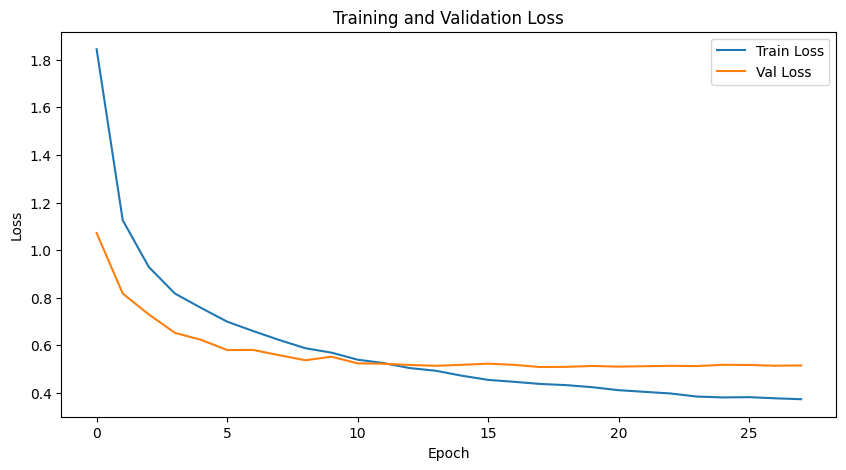

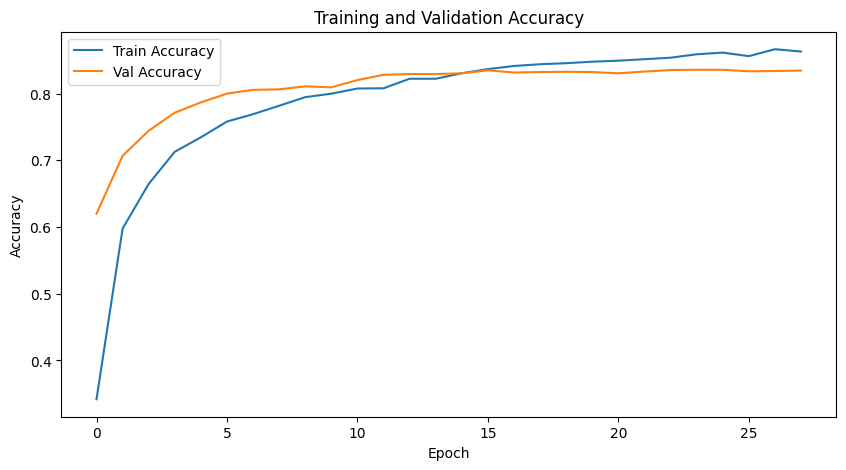

In [ ]:
# Plots training and validation loss and accuracy over epochs

# Plot Loss 
plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


## Evaluation & Analysis

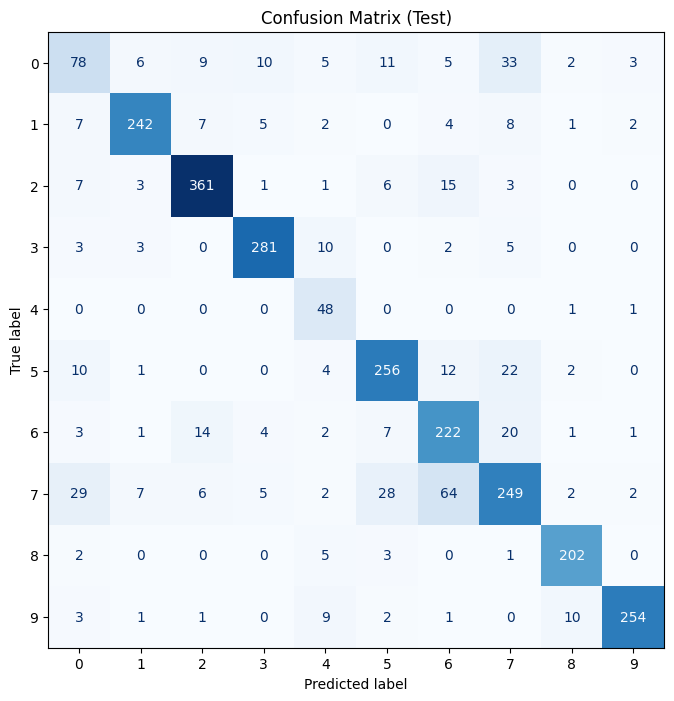


=== Classification Report (per class) ===
              precision    recall  f1-score   support

           0      0.549     0.481     0.513       162
           1      0.917     0.871     0.893       278
           2      0.907     0.909     0.908       397
           3      0.918     0.924     0.921       304
           4      0.545     0.960     0.696        50
           5      0.818     0.834     0.826       307
           6      0.683     0.807     0.740       275
           7      0.730     0.632     0.678       394
           8      0.914     0.948     0.931       213
           9      0.966     0.904     0.934       281

    accuracy                          0.824      2661
   macro avg      0.795     0.827     0.804      2661
weighted avg      0.828     0.824     0.824      2661



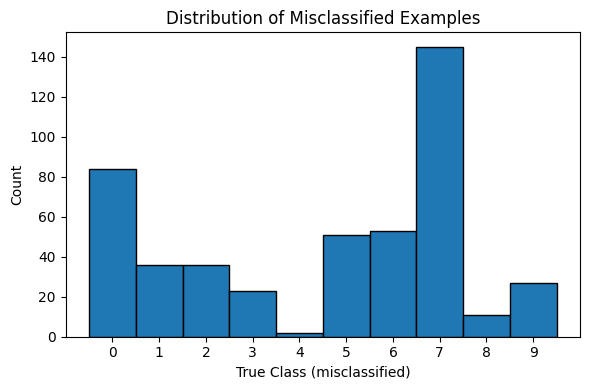

In [ ]:
#  Collect predictions and truths (classification) 
def collect_preds(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                logits = model(xb)              # [B, 10]
            preds = logits.argmax(dim=1)        # class indices
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

# Get predictions
y_true, y_pred = collect_preds(model, test_loader, device)

# Confusion Matrix 
cm = confusion_matrix(y_true, y_pred, labels=range(10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
plt.title("Confusion Matrix (Test)")
plt.show()

# Classification Report 
print("\n=== Classification Report (per class) ===")
print(classification_report(y_true, y_pred, digits=3))

# Error Distribution 
errors = y_pred != y_true
plt.figure(figsize=(6,4))
plt.hist(y_true[errors], bins=np.arange(11)-0.5, edgecolor="black")
plt.xticks(range(10))
plt.xlabel("True Class (misclassified)")
plt.ylabel("Count")
plt.title("Distribution of Misclassified Examples")
plt.tight_layout()
plt.show()